In [1]:
from datetime import datetime, timedelta
import xarray as xr
import numpy as np
import torch
from credit.datasets.era5_multistep_batcher import Predict_Dataset_Batcher
import yaml
from credit.parser import credit_main_parser, predict_data_check
import multiprocessing as mp
from credit.datasets import setup_data_loading
from credit.forecast import load_forecasts
from credit.transforms import load_transforms
from torch.utils.data import Dataset, DataLoader, Sampler, DistributedSampler
import pandas as pd
from glob import glob
from os.path import join
import itertools
import os
import yaml
from credit.models import load_model

from credit.samplers import DistributedMultiStepBatchSampler
from credit.datasets.era5 import ERA5Dataset

import xesmf as xe

In [2]:
path = "/glade/u/home/dkimpara/miles-credit/config/era5_new_data_config.yaml"
with open(path) as cnfg:
    config = yaml.safe_load(cnfg)

data_config = config["data"]

time_config = {
    "timestep": pd.Timedelta(data_config["timestep"]),
    "num_forecast_steps": data_config["forecast_len"] + 1,
    "start_datetime": data_config["start_datetime"],
    "end_datetime": data_config["end_datetime"]
}
source = "ERA5"
dataset = ERA5Dataset(config, time_config, source)

ts = dataset.init_times[0]

In [3]:
sample = dataset[(ts, "init_xarray")]

In [4]:
sample.keys()

dict_keys(['mode', 'stop_forecast', 'dynamic_forcing', 'prognostic', 'static'])

In [5]:
field_types = ["dynamic_forcing", "prognostic", "static"]
ds = xr.merge([sample[field] for field in field_types])

/glade/derecho/scratch/dkimpara/tmp/ipykernel_50910/1920037764.py:2: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.merge([sample[field] for field in field_types])


In [6]:
ds

<xarray.Dataset> Size: 246MB
Dimensions:     (latitude: 640, longitude: 1280, level: 16)
Coordinates:
  * latitude    (latitude) float64 5kB 89.78 89.51 89.23 ... -89.51 -89.78
  * longitude   (longitude) float64 10kB 0.0 0.2812 0.5625 ... 359.2 359.4 359.7
  * level       (level) int64 128B 10 30 40 50 60 70 ... 105 110 120 130 136 137
    time        datetime64[ns] 8B 2021-12-31
Data variables: (12/14)
    tsi         (latitude, longitude) float32 3MB ...
    U           (level, latitude, longitude) float32 52MB ...
    V           (level, latitude, longitude) float32 52MB ...
    T           (level, latitude, longitude) float32 52MB ...
    Q           (level, latitude, longitude) float32 52MB ...
    SP          (latitude, longitude) float32 3MB ...
    ...          ...
    U500        (latitude, longitude) float32 3MB ...
    T500        (latitude, longitude) float32 3MB ...
    Z500        (latitude, longitude) float32 3MB ...
    Q500        (latitude, longitude) float32 3MB ...
    Z_GDS4_SFC  (latitude, longitude) float64 7MB ...
    LSM         (latitude, longitude) float32 3MB ...

In [7]:
zarr_ds = xr.open_dataset("/glade/derecho/scratch/dkimpara/goes-cloud-dataset/goes_10km.zarr")

/glade/derecho/scratch/dkimpara/tmp/ipykernel_50910/2065046676.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  zarr_ds = xr.open_dataset("/glade/derecho/scratch/dkimpara/goes-cloud-dataset/goes_10km.zarr")


In [8]:
ref_array = zarr_ds
padded_lat = np.pad(ref_array.latitude, 
                (11,10), 
                mode="linear_ramp", 
                end_values=(-50.1 - 11* 0.1, 50.1 + 10*.1))
padded_lon = np.pad(ref_array.longitude, 
                (19,18), 
                mode="linear_ramp", 
                end_values=(-121.1 - 19 * 0.1, -28.9 + 18*.1))

In [18]:
ds.to_netcdf("/glade/derecho/scratch/dkimpara/goes-cloud-dataset/ingrid_era5_to_goes.nc", engine="h5netcdf")

In [9]:
da_outgrid = xr.DataArray(np.ones((len(padded_lat), len(padded_lon))), coords=dict(latitude=padded_lat, longitude=padded_lon))

In [15]:
da_outgrid.to_netcdf("/glade/derecho/scratch/dkimpara/goes-cloud-dataset/outgrid_era5_to_goes.nc", engine="h5netcdf")

In [10]:
%%time
regrid_loc = "/glade/derecho/scratch/dkimpara/goes-cloud-dataset/regrid_era5_to_goes.nc"
# generate regridder
regridder = xe.Regridder(ds, da_outgrid, 'bilinear', unmapped_to_nan=True, weights=regrid_loc)

CPU times: user 3.15 s, sys: 624 ms, total: 3.77 s
Wall time: 4.52 s


In [11]:
%%time
dr_out_nan = regridder(ds, skipna=True, na_thres=1.0)

CPU times: user 7.64 s, sys: 1.07 s, total: 8.7 s
Wall time: 10.8 s


In [12]:
regridder.to_netcdf(regrid_loc)

'/glade/derecho/scratch/dkimpara/goes-cloud-dataset/regrid_era5_to_goes.nc'

In [13]:
dr_out_nan

<xarray.Dataset> Size: 582MB
Dimensions:     (latitude: 1024, longitude: 960, level: 16)
Coordinates:
  * latitude    (latitude) float64 8kB -51.2 -51.1 -51.0 ... 50.9 51.0 51.1
  * longitude   (longitude) float64 8kB -123.0 -122.9 -122.8 ... -27.2 -27.1
  * level       (level) int64 128B 10 30 40 50 60 70 ... 105 110 120 130 136 137
    time        datetime64[ns] 8B 2021-12-31
Data variables: (12/14)
    tsi         (latitude, longitude) float64 8MB 2.85e+06 2.847e+06 ... 0.0 0.0
    U           (level, latitude, longitude) float64 126MB -38.86 ... 6.466
    V           (level, latitude, longitude) float64 126MB -4.565 ... 4.745
    T           (level, latitude, longitude) float64 126MB 250.7 250.7 ... 283.2
    Q           (level, latitude, longitude) float64 126MB 4.094e-06 ... 0.00...
    SP          (latitude, longitude) float64 8MB 1.009e+05 ... 9.798e+04
    ...          ...
    U500        (latitude, longitude) float64 8MB 30.86 30.96 ... 4.834 4.635
    T500        (latitude, longitude) float64 8MB 264.0 264.0 ... 246.9 246.9
    Z500        (latitude, longitude) float64 8MB 5.587e+04 ... 5.134e+04
    Q500        (latitude, longitude) float64 8MB 0.003257 ... 0.0004847
    Z_GDS4_SFC  (latitude, longitude) float64 8MB 0.06221 0.06221 ... 0.06224
    LSM         (latitude, longitude) float64 8MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

In [16]:
regridder = xe.Regridder(None,None , 'bilinear', unmapped_to_nan=True, weights=regrid_loc)

TypeError: argument of type 'NoneType' is not iterable

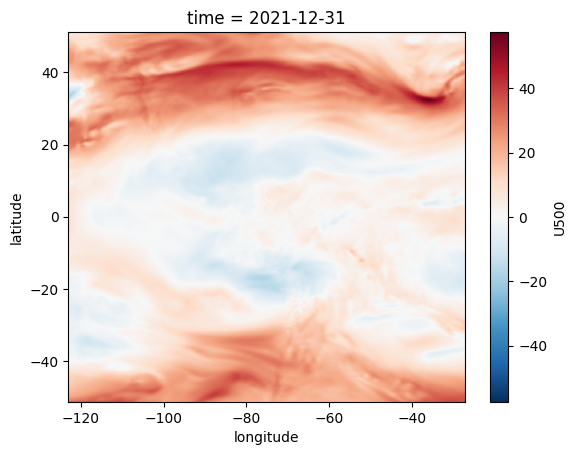

In [14]:
dr_out_nan.U500.plot()

In [19]:
ds

<xarray.Dataset> Size: 246MB
Dimensions:     (latitude: 640, longitude: 1280, level: 16)
Coordinates:
  * latitude    (latitude) float64 5kB 89.78 89.51 89.23 ... -89.51 -89.78
  * longitude   (longitude) float64 10kB 0.0 0.2812 0.5625 ... 359.2 359.4 359.7
  * level       (level) int64 128B 10 30 40 50 60 70 ... 105 110 120 130 136 137
    time        datetime64[ns] 8B 2021-12-31
Data variables: (12/14)
    tsi         (latitude, longitude) float32 3MB 0.0 0.0 ... 1.642e+06
    U           (level, latitude, longitude) float32 52MB -0.1794 ... 0.4449
    V           (level, latitude, longitude) float32 52MB 14.14 14.14 ... -7.014
    T           (level, latitude, longitude) float32 52MB 250.0 250.0 ... 250.2
    Q           (level, latitude, longitude) float32 52MB 2.656e-06 ... 0.000...
    SP          (latitude, longitude) float32 3MB 1.029e+05 ... 6.902e+04
    ...          ...
    U500        (latitude, longitude) float32 3MB -11.62 -11.6 ... 4.024 4.075
    T500        (latitude, longitude) float32 3MB 233.5 233.5 ... 235.1 235.1
    Z500        (latitude, longitude) float32 3MB 5.129e+04 ... 4.962e+04
    Q500        (latitude, longitude) float32 3MB 0.0001694 ... 0.0001987
    Z_GDS4_SFC  (latitude, longitude) float64 7MB 0.06226 0.06226 ... 0.06226
    LSM         (latitude, longitude) float32 3MB 0.0 0.0 0.0 ... 1.0 1.0 1.0

In [22]:
pd.Timestamp(ds.time.values).year

2021